# SensRay Ray Tracing & Sensitivity Kernels Demo

This notebook demonstrates:
- Ray tracing with ObsPy/TauP integration
- Computing per-cell ray path lengths
- Calculating sensitivity kernels
- Visualizing rays and kernels in cross-sections

In [1]:
import os
# Top-level INTERACTIVE switch: set to True for interactive Jupyter widgets,
# or False to force static/off-screen rendering and enable screenshot-based outputs.
INTERACTIVE = True

# If not interactive, set PyVista to off-screen mode. If interactive, prefer ipyvtklink/panel.
if not INTERACTIVE:
    os.environ['PYVISTA_OFF_SCREEN'] = 'true'
    os.environ['PYVISTA_USE_IPYVTK'] = 'false'
else:
    os.environ.pop('PYVISTA_OFF_SCREEN', None)
    # Prefer ipyvtklink for Jupyter interactive 3D plots (requires ipyvtklink installed)
    os.environ['PYVISTA_USE_IPYVTK'] = 'true'

import numpy as np
from sensray import PlanetModel, CoordinateConverter

# Configure PyVista backend according to INTERACTIVE flag
try:
    import pyvista as pv
    if INTERACTIVE:
        try:
            pv.set_jupyter_backend('ipyvtklink')
            print("Configured PyVista for interactive plotting using ipyvtklink")
        except Exception:
            try:
                pv.set_jupyter_backend('panel')
                print("Configured PyVista for interactive plotting using panel")
            except Exception as e:
                print(f"Warning: Could not set interactive PyVista backend: {e}")
    else:
        pv.set_jupyter_backend('static')
        print("Configured PyVista for static/off-screen plotting")
except Exception as e:
    print(f"Warning: Could not import/configure pyvista: {e}")

Use one of the following:
"static", "client", "server", "trame", "html", "none"


## 1. Setup Model and Mesh

Create a model and mesh for ray tracing experiments.

### Creating a layered tetrahedral mesh (discontinuities)

This demo uses a layered, concentric-sphere tetrahedral mesh so you can control resolution across major internal interfaces (discontinuities). The mesher accepts these main controls:

- `radii` (list of floats, ascending): interface radii in km (last entry must be the outer radius).
- `H_layers` (list of floats): target element size per layer (km). If `None`, `mesh_size_km` is used for all layers.
- `W_trans` (list of floats): half-widths for smooth size transitions at interfaces (km). If omitted, a default ~0.2*layer_thickness is used.

Notes:
- Units are kilometres throughout the API.
- For a uniform sphere just omit `radii` and set `mesh_size_km`.

Example (run this when creating a new mesh):
```python
radii = [1221.5, 3480.0, 6371.0]
H_layers = [500.0, 500.0, 300.0]
W_trans = [50.0, 100.0]  # optional
# Create mesh (use do_optimize=False for faster development)
model.create_mesh(mesh_size_km=1000.0, radii=radii, H_layers=H_layers, W_trans=W_trans, do_optimize=False)
model.mesh.populate_properties(['vp', 'vs', 'rho'])
model.mesh.save('prem_mesh.vtu')  # file extension recommended
```

In [2]:
# Load model and create mesh
model = PlanetModel.from_standard_model('M1')
# Create mesh and save if not exist, otherwise load existing
print(model.get_discontinuities())
mesh_path = "M1_mesh"
try:
    model.create_mesh(from_file=mesh_path)
    print(f"Loaded existing mesh from {mesh_path}")
except FileNotFoundError:
    print("Creating new mesh...")
    radii = [397.1, 1687.0, 1737.1]
    H_layers = [200, 200, 200]
    model.create_mesh(mesh_size_km=1000, radii=radii, H_layers=H_layers)
    model.mesh.populate_properties(['vp', 'vs', 'rho'])
    model.mesh.save("M1_mesh")  # Save mesh to VT
print(f"Created mesh: {model.mesh.mesh.n_cells} cells")

[397.0999999999999, 1687.1]
Creating new mesh...
Info    : Meshing 1D...nts                                                                                                                
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 50%] Meshing curve 5 (Circle)
Info    : [ 80%] Meshing curve 8 (Circle)
Info    : Done meshing 1D (Wall 0.00101618s, CPU 0.011282s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Sphere, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Sphere, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Sphere, Frontal-Delaunay)


/home/adrian/PhD/masters/SensRay/sensray/planet_mesh.py:1814: UserWarning: Metadata file not found: M1_mesh_metadata.json
  warnings.warn(f"Metadata file not found: {metadata_path}")


Info    : Done meshing 2D (Wall 0.133252s, CPU 0.182906s)
Info    : Meshing 3D...
Info    : 3D Meshing 3 volumes with 1 connected component
Info    : Tetrahedrizing 2316 nodes...
Info    : Done tetrahedrizing 2324 nodes (Wall 0.0187335s, CPU 0.009176s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0485171s, CPU 0.02974s)
Info    : Found volume 3
Info    : Found volume 1
Info    : Found volume 2
Info    : It. 0 - 0 nodes created - worst tet radius 3.62317 (nodes removed 0 0)
Info    : It. 500 - 496 nodes created - worst tet radius 1.32731 (nodes removed 0 4)
Info    : It. 1000 - 995 nodes created - worst tet radius 1.09622 (nodes removed 0 5)
Info    : 3D refinement terminated (3675 nodes total):
Info    :  - 0 Delaunay cavities modified for star shapeness
Info    :  - 7 nodes could not be inserted
Info    :  - 19331 tetrahedra created in 0.0657892 se

Info: VTU format cannot write cell_sets. Converting them to cell_data...

Generated tetrahedral mesh: 17761 cells, 3588 points
Populated properties: ['vp', 'vs', 'rho']
Saved mesh to M1_mesh.vtu
Saved metadata to M1_mesh_metadata.json
Created mesh: 17761 cells


## 2. Define Source-Receiver Geometry

Set up a realistic earthquake-station pair.

In [3]:
# Define source (earthquake) and receiver (seismic station) locations
source_lat, source_lon, source_depth = 0.0, 0.0, 10.0  # Equator, 10 km depth
receiver_lat, receiver_lon = 70.0, 45.0  # Surface station

# Compute great-circle plane normal for cross-sections
plane_normal = CoordinateConverter.compute_gc_plane_normal(
    source_lat, source_lon, receiver_lat, receiver_lon
)
print(f"Source: ({source_lat}°, {source_lon}°, {source_depth} km)")
print(f"Receiver: ({receiver_lat}°, {receiver_lon}°, 0 km)")
print(f"Great-circle plane normal: {plane_normal}")

Source: (0.0°, 0.0°, 10.0 km)
Receiver: (70.0°, 45.0°, 0 km)
Great-circle plane normal: (0.0, -0.9684408309910914, 0.24924356936395423)


## 3. Ray Tracing with TauP

Compute ray paths for different seismic phases.

Building obspy.taup model for '/home/adrian/PhD/masters/SensRay/sensray/models/M1.nd' ...
filename = /home/adrian/PhD/masters/SensRay/sensray/models/M1.nd
Done reading velocity model.
Radius of model . is 1737.1
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  643 P layers,747 S layers
Done calculating Tau branches.
Done Saving /tmp/M1.npz
Method run is done, but not necessarily successful.


/tmp/ipykernel_29269/2403894358.py:11: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  rays.plot()


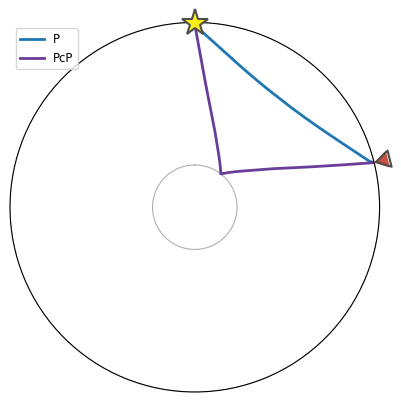

Found 2 ray paths:
  1. P: 284.14 s, 438 points
  2. PcP: 379.22 s, 1004 points


In [4]:
# Get ray paths for P and S waves
rays = model.taupy_model.get_ray_paths_geo(
    source_depth_in_km=source_depth,
    source_latitude_in_deg=source_lat,
    source_longitude_in_deg=source_lon,
    receiver_latitude_in_deg=receiver_lat,
    receiver_longitude_in_deg=receiver_lon,
    phase_list=["P", "PcP"]
)

rays.plot()

print(f"Found {len(rays)} ray paths:")
for i, ray in enumerate(rays):
    print(f"  {i+1}. {ray.phase.name}: {ray.time:.2f} s, {len(ray.path)} points")

## 4. Compute Ray Path Lengths

Calculate how much each ray travels through each mesh cell.

In [5]:
# Compute and store path lengths for each ray
P_ray = rays[0]  # First ray (P wave)
PcP_ray = rays[1]  # Second ray (PcP wave)

# Method 1: Simple computation and storage
P_lengths = model.mesh.add_ray_to_mesh(P_ray, "P_wave")
PcP_lengths = model.mesh.add_ray_to_mesh(PcP_ray, "PcP_wave")

print(f"P wave: {P_lengths.sum():.1f} km total, {np.count_nonzero(P_lengths)} cells")
print(f"PcP wave: {PcP_lengths.sum():.1f} km total, {np.count_nonzero(PcP_lengths)} cells")

# Show stored properties
ray_keys = [k for k in model.mesh.mesh.cell_data.keys() if 'ray_' in k]
print(f"Stored ray properties: {ray_keys}")

Stored ray path lengths as cell data: 'ray_P_wave_P_lengths'
Stored ray path lengths as cell data: 'ray_PcP_wave_PcP_lengths'
P wave: 2138.7 km total, 36 cells
PcP wave: 2878.3 km total, 43 cells
Stored ray properties: ['ray_P_wave_P_lengths', 'ray_PcP_wave_PcP_lengths']


### And visualization

In [6]:
# Cross-section showing background Vp
print("Background P-wave velocity:")
plotter1 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='vp',
    show_rays=rays,  # Overlay ray path
)
plotter1.camera.position = (8000, 6000, 10000)
# Use INTERACTIVE switch to control whether show() presents an interactive widget or a static render.
# If INTERACTIVE is False and you want an image, call plotter1.screenshot('vp_background.png')
plotter1.show(interactive=INTERACTIVE)


Background P-wave velocity:


Widget(value='<iframe src="http://localhost:42495/index.html?ui=P_0x7fb9e7231ed0_0&reconnect=auto" class="pyvi…

In [7]:
# Cross-section showing P-wave ray path lengths
print("P-wave path lengths through cells:")
plotter2 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='ray_P_wave_P_lengths',
    show_rays=[P_ray],
)
plotter2.camera.position = (8000, 6000, 10000)
# Use INTERACTIVE switch
plotter2.show(interactive=INTERACTIVE)

P-wave path lengths through cells:


Widget(value='<iframe src="http://localhost:42495/index.html?ui=P_0x7fb870b7f210_1&reconnect=auto" class="pyvi…

## 5. Sensitivity Kernels

Compute travel-time sensitivity kernels: K = -L / v² for each cell.

In [9]:
# Compute sensitivity kernels for P and S waves
P_kernel = model.mesh.compute_sensitivity_kernel(
    P_ray, property_name='vp', attach_name='K_P_vp', epsilon=1e-6
)
PcP_kernel = model.mesh.compute_sensitivity_kernel(
    PcP_ray, property_name='vs', attach_name='K_PcP_vs', epsilon=1e-6
)

print(f"P kernel range: {P_kernel.min():.6f} to {P_kernel.max():.6f} s²/km³")
print(f"PcP kernel range: {PcP_kernel.min():.6f} to {PcP_kernel.max():.6f} s²/km³")
print(f"Non-zero P kernel cells: {np.count_nonzero(P_kernel)}")
print(f"Non-zero PcP kernel cells: {np.count_nonzero(PcP_kernel)}")

Stored sensitivity kernel as cell data: 'K_P_vp'
Stored sensitivity kernel as cell data: 'K_PcP_vs'
P kernel range: -3.121696 to -0.000000 s²/km³
PcP kernel range: -15.243494 to -0.000000 s²/km³
Non-zero P kernel cells: 36
Non-zero PcP kernel cells: 43


In [13]:
plotter3 = model.mesh.plot_cross_section(
    plane_normal,
    property_name='K_P_vp',
    show_rays=[P_ray],
    cmap='magma',
)
# Interactive display for kernel cross-section
plotter3.show(interactive=INTERACTIVE)

Widget(value='<iframe src="http://localhost:42495/index.html?ui=P_0x7fb84d01ff50_4&reconnect=auto" class="pyvi…

## 6. Multiple Ray Kernels

Combine kernels from multiple rays for enhanced sensitivity.

In [19]:
# Sum kernels from multiple rays
if len(rays) >= 2:
    combined_kernel = model.mesh.compute_sensitivity_kernel(
        rays,  # Use PcP rays
        property_name='vp',
        attach_name='K_combined_vp',
        accumulate='sum'
    )
    print(f"Combined kernel range: {combined_kernel.min():.6f} to {combined_kernel.max():.6f}")
    print(f"Combined kernel non-zero cells: {np.count_nonzero(combined_kernel)}")

Stored summed sensitivity kernel as cell data: 'K_combined_vp'
Combined kernel range: -3.399894 to 0.000000
Combined kernel non-zero cells: 71


In [20]:
plotter4 = model.mesh.plot_cross_section(
    plane_normal,
    property_name='K_combined_vp',
    show_rays=[P_ray, PcP_ray],
    cmap='magma',
)
# Interactive display
plotter4.show(interactive=INTERACTIVE)

Widget(value='<iframe src="http://localhost:42495/index.html?ui=P_0x7fb82c9a6310_7&reconnect=auto" class="pyvi…

## 8. Export Results

Save mesh with all computed properties for further analysis.

In [21]:
# Save mesh with rays and kernels
model.mesh.save('prem_mesh_with_rays_kernels')

# Show what was saved
info = model.mesh.list_properties(show_stats=False)
print(f"Saved {len(info['cell_data'])} properties to VTU file:")
for prop in info['cell_data'].keys():
    print(f"  - {prop}")

print("\nFiles created:")
print("  - prem_mesh_with_rays_kernels.vtu (mesh + all data)")
print("  - prem_mesh_with_rays_kernels_metadata.json (property list)")

Saved mesh to prem_mesh_with_rays_kernels.vtu
Saved metadata to prem_mesh_with_rays_kernels_metadata.json
Mesh properties summary:
  cell_data keys: ['gmsh:physical', 'gmsh:geometrical', 'layer_0-layer_1-layer_2-gmsh:bounding_entities', 'region', 'vp', 'vs', 'rho', 'ray_P_wave_P_lengths', 'ray_PcP_wave_PcP_lengths', 'K_P_vp', 'K_PcP_vs', 'K_combined_vs', 'K_combined_vp']
Saved 13 properties to VTU file:
  - gmsh:physical
  - gmsh:geometrical
  - layer_0-layer_1-layer_2-gmsh:bounding_entities
  - region
  - vp
  - vs
  - rho
  - ray_P_wave_P_lengths
  - ray_PcP_wave_PcP_lengths
  - K_P_vp
  - K_PcP_vs
  - K_combined_vs
  - K_combined_vp

Files created:
  - prem_mesh_with_rays_kernels.vtu (mesh + all data)
  - prem_mesh_with_rays_kernels_metadata.json (property list)
